![image.png](attachment:image.png)

In [28]:
!pip install pycaret

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from pycaret.regression import create_model
from pycaret.classification import *


from scipy.stats import ks_2samp
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp
from scipy.stats import t

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import warnings

In [30]:
sns.set_style("whitegrid")

In [31]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [33]:
# Ordenando o dataframe por data
df.sort_values('data_ref', inplace=True)

# Encontrando a data de corte para os últimos três meses
cutoff_date = df['data_ref'].max() - pd.DateOffset(months=3)

# Separando o dataframe em treino e validação (oot)
train_df = df[df['data_ref'] < cutoff_date]
oot_df = df[df['data_ref'] >= cutoff_date]

# Removendo as colunas 'data_ref' e 'index' que não serão usadas na modelagem
train_df = train_df.drop(columns=['data_ref', 'index'])
oot_df = oot_df.drop(columns=['data_ref', 'index'])

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [34]:
# Número de linhas
num_rows = len(df)
print(f"Número de linhas: {num_rows}")

# Número de linhas para cada mês em 'data_ref'
num_rows_per_month = df['data_ref'].value_counts()
print("\nNúmero de linhas para cada mês em 'data_ref':")
print(num_rows_per_month)

Número de linhas: 750000

Número de linhas para cada mês em 'data_ref':
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


In [35]:
# Descritiva básica univariada de cada variável
for col in df.columns:
    print(f"\nDescritiva básica univariada para '{col}':")
    if df[col].dtype == 'object':  # Variáveis qualitativas
        print(df[col].value_counts())
    else:  # Variáveis quantitativas
        print(df[col].describe())


Descritiva básica univariada para 'data_ref':
count                 750000
mean     2015-08-01 06:24:00
min      2015-01-01 00:00:00
25%      2015-04-01 00:00:00
50%      2015-08-01 00:00:00
75%      2015-12-01 00:00:00
max      2016-03-01 00:00:00
Name: data_ref, dtype: object

Descritiva básica univariada para 'index':
count    750000.000000
mean       8319.272793
std        4809.281774
min           0.000000
25%        4147.000000
50%        8324.000000
75%       12487.000000
max       16649.000000
Name: index, dtype: float64

Descritiva básica univariada para 'sexo':
sexo
F    504580
M    245420
Name: count, dtype: int64

Descritiva básica univariada para 'posse_de_veiculo':
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64

Descritiva básica univariada para 'posse_de_imovel':
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64

Descritiva básica univariada para 'qtd_filhos':
count    750000.000000
mean          0.433251
std           0.739379
min   

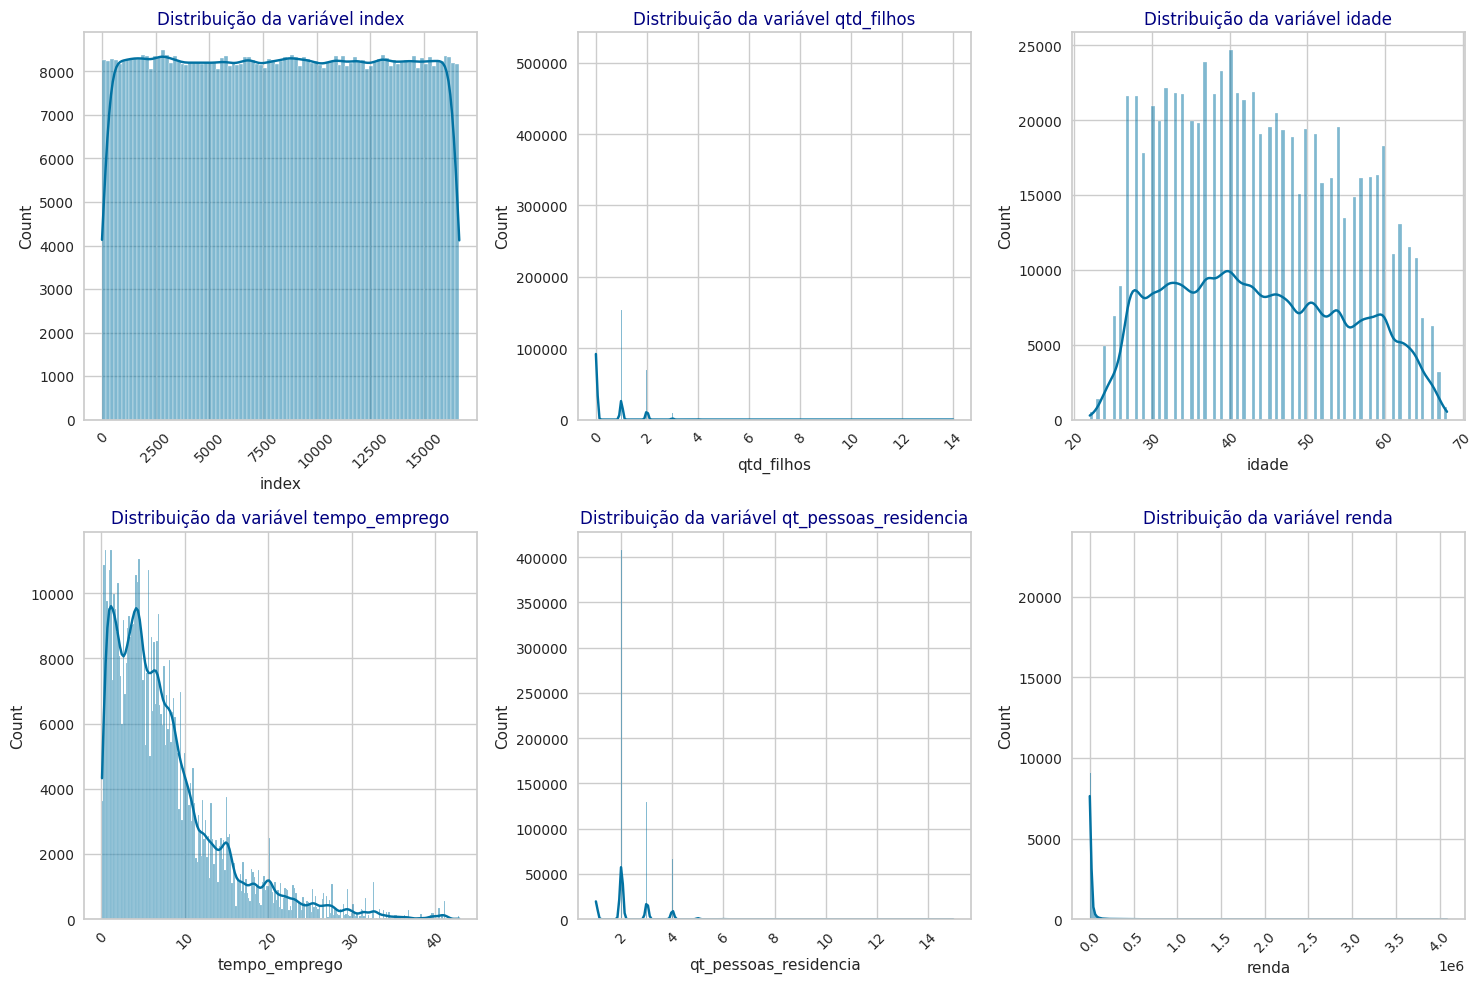

In [36]:
# Gráficos para variáveis quantitativas
quant_vars = df.select_dtypes(include=[np.number]).columns
n_rows = int(np.ceil(len(quant_vars)/3))
fig, axs = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axs = axs.flatten()  # para facilitar a iteração
for i, col in enumerate(quant_vars):
    sns.histplot(data=df, x=col, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribuição da variável {col}', color='navy')
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

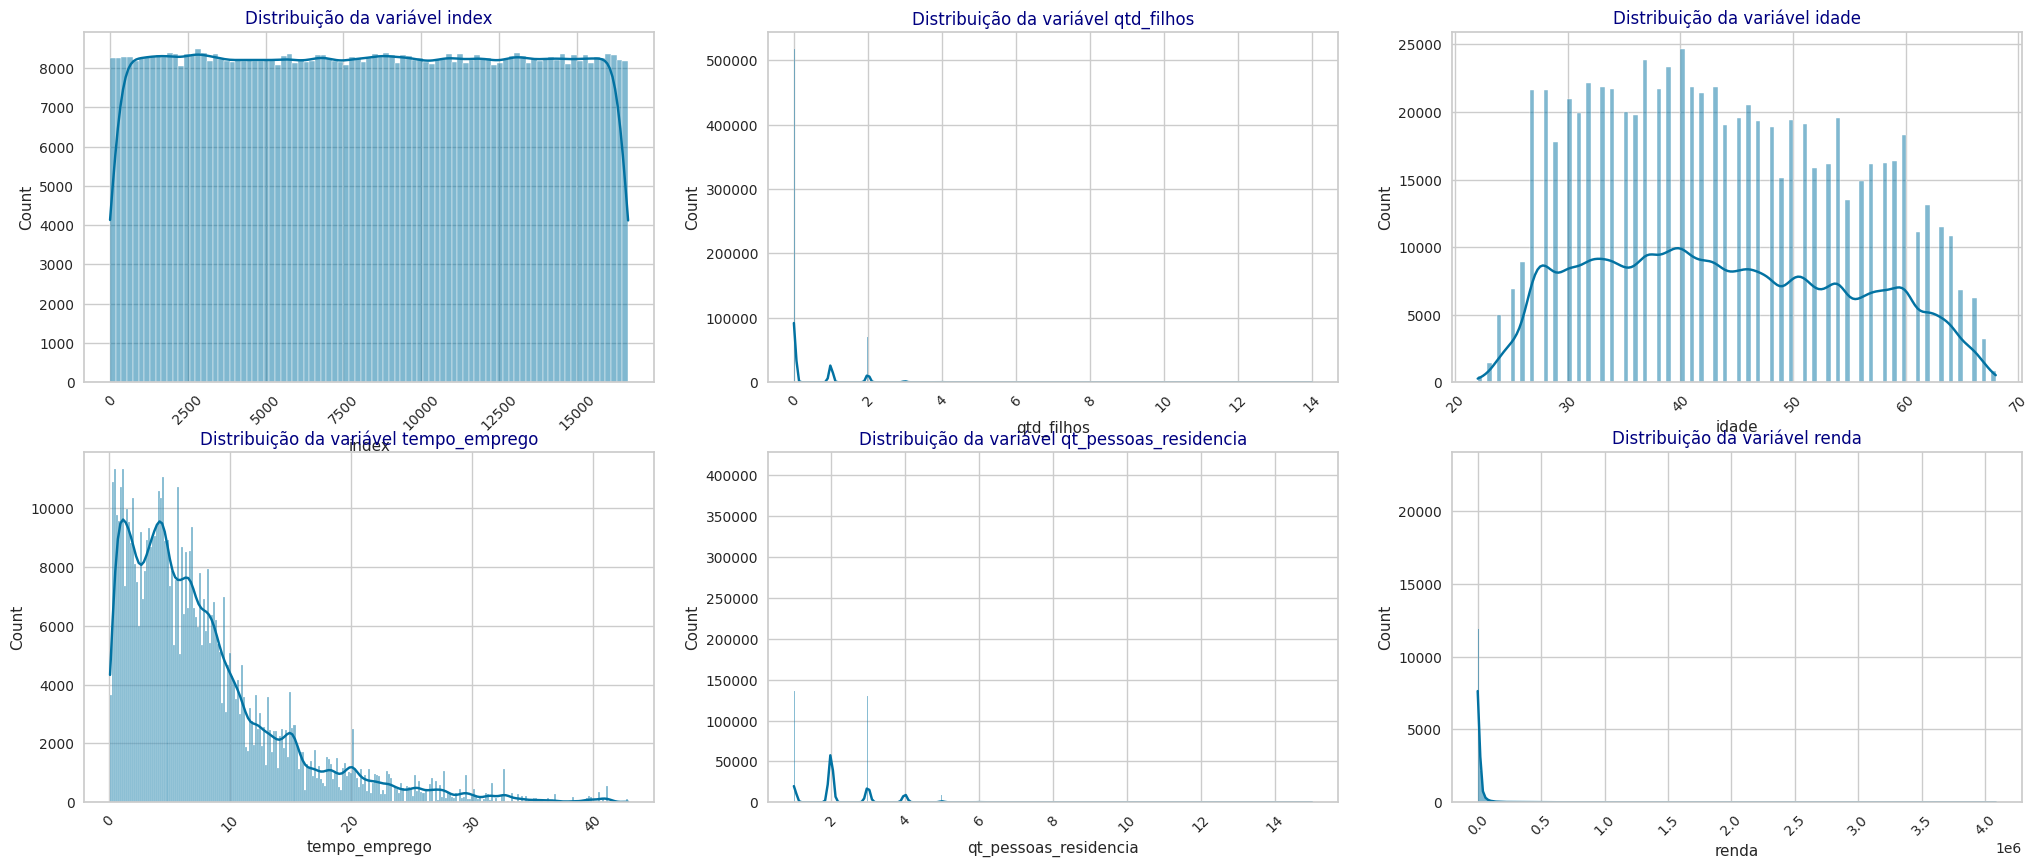

In [37]:
# Gráficos para variáveis quantitativas
quant_vars = df.select_dtypes(include=[np.number]).columns
n_rows = int(np.ceil(len(quant_vars)/3))
fig, axs = plt.subplots(n_rows, 3, figsize=(25, 5*n_rows))
axs = axs.flatten()  # para facilitar a iteração
for i, col in enumerate(quant_vars):
    sns.histplot(data=df, x=col, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribuição da variável {col}', color='navy')
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
plt.show()

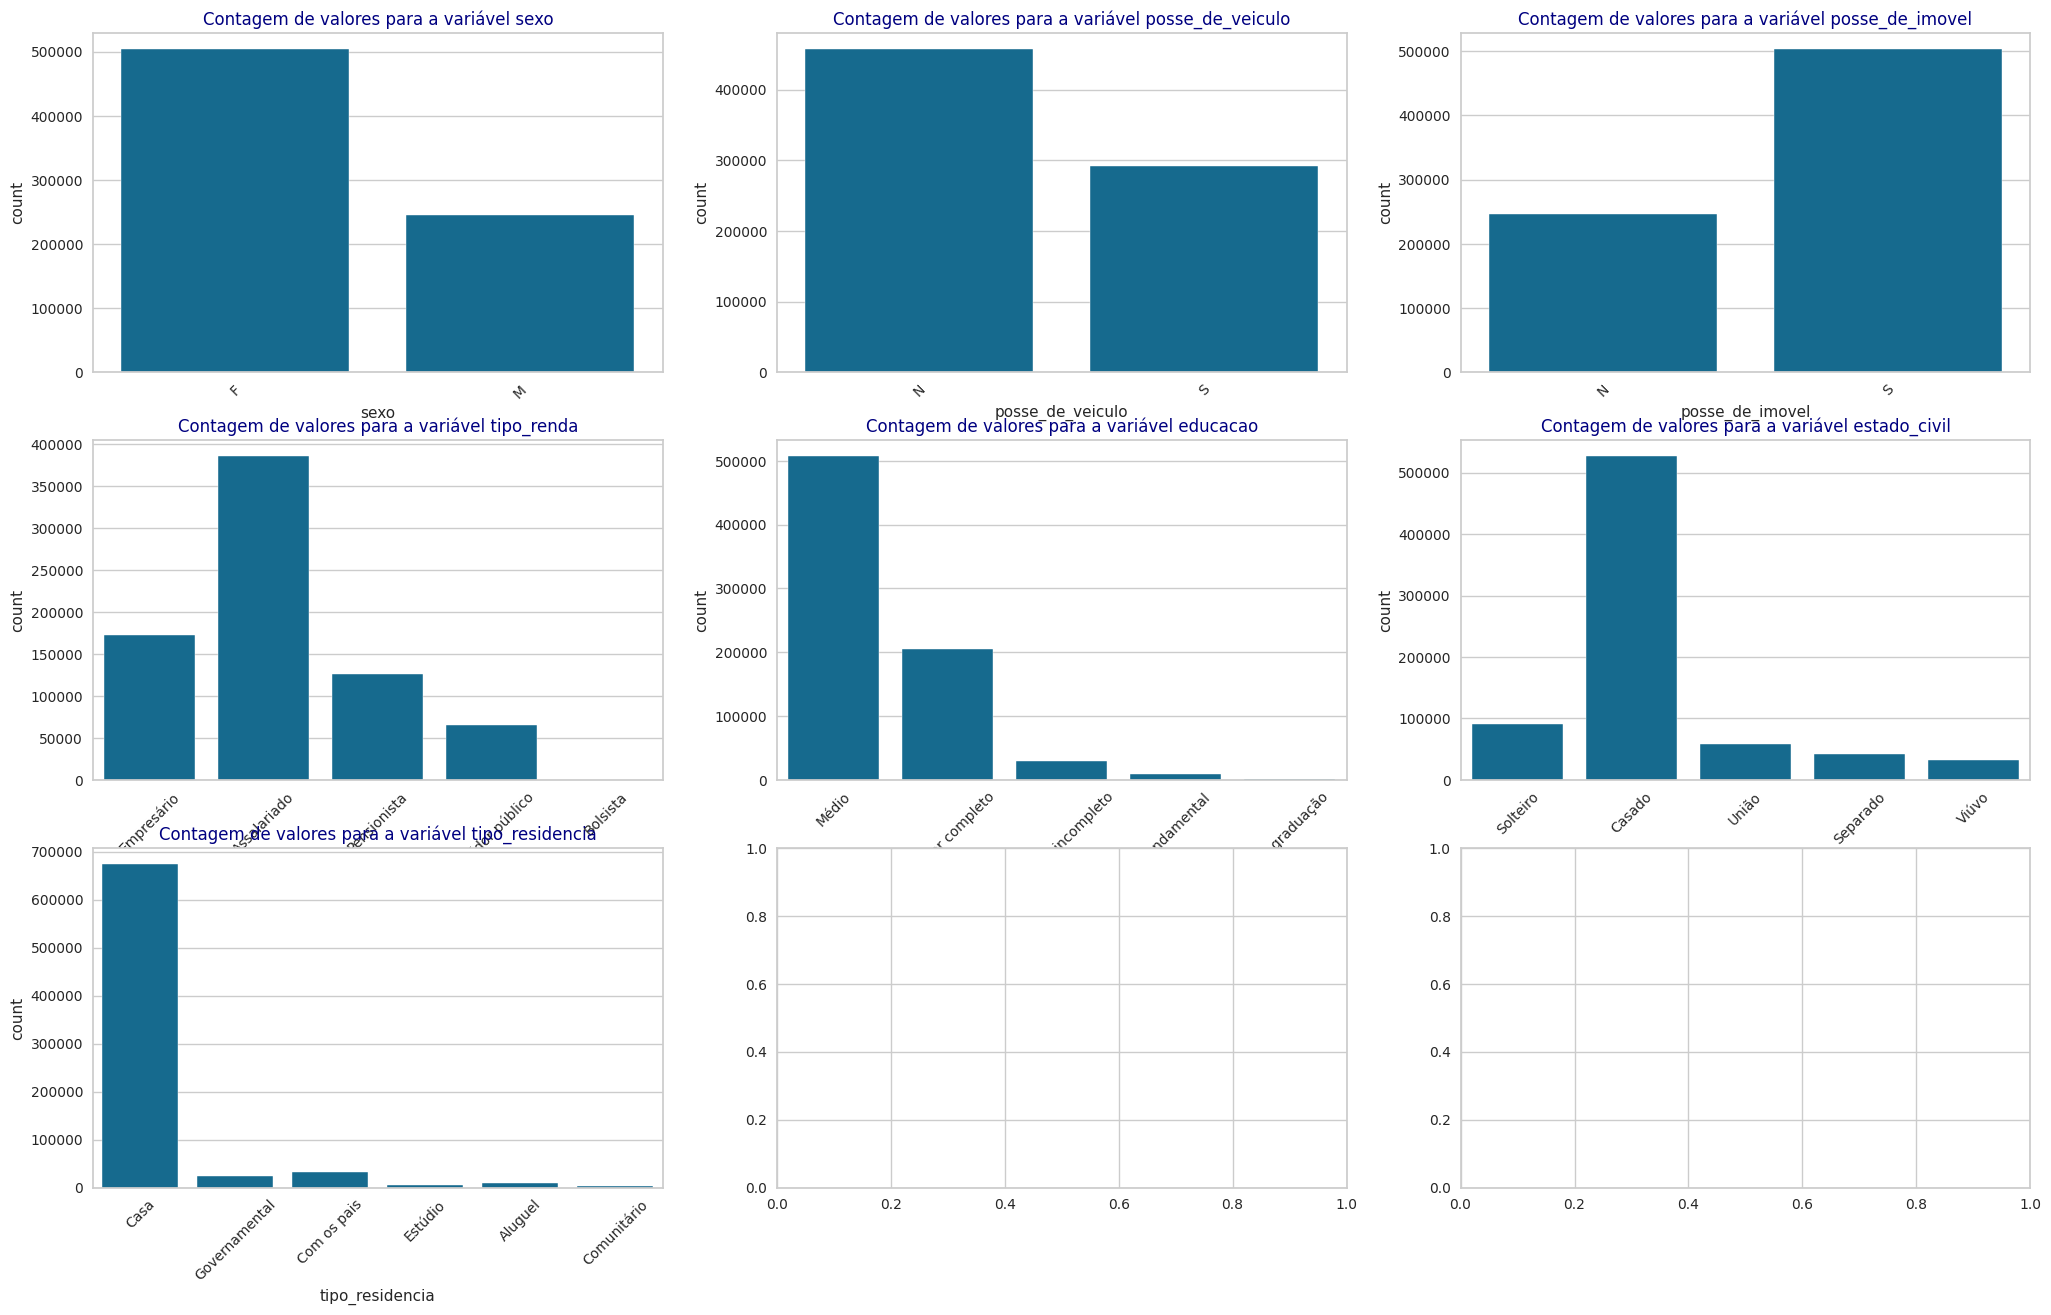

In [38]:
# Gráficos para variáveis qualitativas
qual_vars = df.select_dtypes(include=['object']).columns
n_rows = int(np.ceil(len(qual_vars)/3))
fig, axs = plt.subplots(n_rows, 3, figsize=(25, 5*n_rows))
axs = axs.flatten()  # para facilitar a iteração
for i, col in enumerate(qual_vars):
    sns.countplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(f'Contagem de valores para a variável {col}', color='navy')  # altere 'navy' para a cor desejada
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [39]:
# Preenchendo os valores missing com a mediana (para variáveis numéricas) ou a moda (para variáveis categóricas)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

In [40]:
# Substitua os outliers pelo valor do percentil 95 (para valores altos) ou percentil 5 (para valores baixos)
for col in df.select_dtypes(include=[np.number]).columns:
    P95 = df[col].quantile(0.95)
    P5 = df[col].quantile(0.05)
    df[col] = np.where(df[col] > P95, P95, df[col])
    df[col] = np.where(df[col] < P5, P5, df[col])

# Substituindo os 'zeros estruturais' pela mediana
for col in df.select_dtypes(include=[np.number]).columns:
    median = df.loc[df[col] != 0, col].median()
    df[col] = np.where(df[col] == 0, median, df[col])

# Substituindo a variável de data/hora por várias variáveis numéricas
for col in df.select_dtypes(include=['datetime64']).columns:
    df[col+'_ano'] = df[col].dt.year
    df[col+'_mes'] = df[col].dt.month
    df[col+'_dia'] = df[col].dt.day
    df[col+'_dia_da_semana'] = df[col].dt.weekday
    df = df.drop(col, axis=1)

# Agrupando as categorias com frequências muito baixas em uma única categoria 'Outros'
for col in df.select_dtypes(include=['object']).columns:
    freq = df[col].value_counts(normalize=True)
    small_categories = freq[freq < 0.01].index
    df[col] = np.where(df[col].isin(small_categories), 'Outros', df[col])

# Codificação das variáveis categóricas
df = pd.get_dummies(df, drop_first=True)
# Separação das variáveis independentes e dependente
X = df.drop('mau', axis=1)
y = df['mau']
# Divisão dos dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Padronização das variáveis independentes
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Ajuste do modelo de regressão logística
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [41]:
# Avaliação do modelo
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[138364      0]
 [ 11636      0]]
              precision    recall  f1-score   support

       False       0.92      1.00      0.96    138364
        True       0.00      0.00      0.00     11636

    accuracy                           0.92    150000
   macro avg       0.46      0.50      0.48    150000
weighted avg       0.85      0.92      0.89    150000



## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [42]:
# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy}')

# Calculando o KS
ks_statistic, ks_pvalue = ks_2samp(y_pred[y_test == 0], y_pred[y_test == 1])
print(f'KS: {ks_statistic}')

# Calculando o Gini
roc_auc = roc_auc_score(y_test, y_pred)
gini = 2*roc_auc - 1
print(f'Gini: {gini}')

Acurácia: 0.9224266666666666
KS: 0.0
Gini: 0.0


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [43]:
# Recarregando a base
df = pd.read_feather('credit_scoring.ftr')
df.drop(['data_ref', 'index'], axis=1, inplace=True)

In [44]:
df.isnull().sum()

sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [45]:
# Função para substituição de nulos.
def verifica_nulos(df):
    for coluna in df.columns:
        if df[coluna].isnull().sum() > 0:
            if df[coluna].dtype in [np.float64, np.int64]:
                df[coluna].fillna(df[coluna].mean(), inplace=True)
            else:
                df.dropna(subset=[coluna], inplace=True)
    return df


verifica_nulos(df)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,7.748574,1.0,1389.39,False
749997,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [46]:
# Função para remoção de outliers
def remove_outliers_iqr(df):
    for coluna in df.columns:
        if np.issubdtype(df[coluna].dtype, np.number):
            # Valores do quartil 25 e quartil 75
            q25, q75 = np.percentile(df[coluna],
                                     25), np.percentile(df[coluna], 75)

            # Interquartile range
            coluna_iqr = q75 - q25

            # Limiar
            coluna_cut_off = coluna_iqr * 1.5
            # Limite superior e inferior
            coluna_lower, coluna_upper = q25 - coluna_cut_off, q75 + coluna_cut_off

            # DataFrame sem os outliers
            df = df[(df[coluna] >= coluna_lower)
                    & (df[coluna] <= coluna_upper)].copy()

    return df

print(f'Quantidade de linhas e colunas antes de remover outliers: {df.shape}')
df = remove_outliers_iqr(df)
print(f'Quantidade de linhas e colunas depois de remover outliers: {df.shape}')

Quantidade de linhas e colunas antes de remover outliers: (750000, 13)
Quantidade de linhas e colunas depois de remover outliers: (625133, 13)


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance?

In [47]:
#Criando função para seleção de variáveis



def seleciona_variaveis(df, target):
    # Separando os dados em features (X) e variável alvo (y)
    X = df.drop(target, axis=1)
    y = df[target]

    # Aplicando a codificação one-hot para as colunas categóricas
    categorical_cols = df.select_dtypes(include=['object']).columns
    X = pd.get_dummies(X, columns=categorical_cols)

    # Criando o modelo de RandomForestClassifier
    model = RandomForestClassifier()

    # Treinando o modelo
    model.fit(X, y)

    # Obtendo a importância das features
    feature_importance = pd.Series(
        model.feature_importances_,
        index=X.columns).sort_values(ascending=False)

    # Retornando as top N variáveis mais importantes
    N = 8  # Defina o número de variáveis que deseja manter
    top_features = feature_importance[:N]

    return top_features


seleciona_variaveis(df, 'mau')

renda                     0.783346
tempo_emprego             0.079182
idade                     0.073656
qt_pessoas_residencia     0.007394
qtd_filhos                0.005822
posse_de_veiculo_S        0.003507
posse_de_veiculo_N        0.003494
tipo_renda_Assalariado    0.003339
dtype: float64

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [48]:
def pca(df, target):

    # Separando os dados em features (X) e variável alvo (y)
    X = df.drop(target, axis=1)
    y = df[target]

    # Aplicando a codificação one-hot para as colunas categóricas
    categorical_cols = df.select_dtypes(include=['object']).columns
    X = pd.get_dummies(X, columns=categorical_cols)

    # Criando uma instância do PCA com o número de componentes desejado
    n_components = 5
    pca = PCA(n_components=n_components)
    pca.fit(X)

    # Ajustando o PCA aos dados
    X_pca = pca.transform(X)

    # Criando um DataFrame para as componentes principais
    pca_df = pd.DataFrame(data=X_pca)

    return pca_df


pca(df, 'mau')
df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1.
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [52]:
#Função para get_dummies para columas catégoricas do dataframe
def get_dummies(df):
    df = pd.get_dummies(df, drop_first=True)
    return df


get_dummies(df)

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Bolsista,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0,43,6.873973,1.0,2515.39,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
1,0,35,4.526027,2.0,3180.19,False,False,True,True,False,...,False,False,False,False,False,True,False,False,False,False
2,2,31,0.243836,4.0,1582.29,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,0,54,12.772603,2.0,13721.17,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,0,31,8.432877,1.0,2891.08,False,False,True,False,False,...,True,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,0,48,3.038356,2.0,2109.99,False,True,False,True,False,...,False,False,False,False,False,True,False,False,False,False
749996,0,65,7.748574,1.0,1389.39,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
749997,2,43,10.375342,4.0,649.06,True,True,True,False,False,...,False,False,False,False,False,True,False,False,False,False
749998,0,56,13.780822,1.0,4216.72,True,False,False,True,False,...,False,False,False,False,True,True,False,False,False,False


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 625133 entries, 0 to 749999
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   qtd_filhos                     625133 non-null  int64  
 1   idade                          625133 non-null  int64  
 2   tempo_emprego                  625133 non-null  float64
 3   qt_pessoas_residencia          625133 non-null  float64
 4   renda                          625133 non-null  float64
 5   mau                            625133 non-null  bool   
 6   sexo_M                         625133 non-null  bool   
 7   posse_de_veiculo_S             625133 non-null  bool   
 8   posse_de_imovel_S              625133 non-null  bool   
 9   tipo_renda_Bolsista            625133 non-null  bool   
 10  tipo_renda_Empresário          625133 non-null  bool   
 11  tipo_renda_Pensionista         625133 non-null  bool   
 12  tipo_renda_Servidor público    6251

### Pipeline

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [55]:
#criando pipeline preprocessamento()

preprocessamento = Pipeline(
    steps=[('verifica_nulos',
            verifica_nulos(df)), ('remove_outliers',
                                  remove_outliers_iqr(df)), ('pca'),
           pca(df, 'mau'), ('get_dummies', get_dummies(df))])

preprocessamento

TypeError:         qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia     renda  \
0                0     43       6.873973                    1.0   2515.39   
1                0     35       4.526027                    2.0   3180.19   
2                2     31       0.243836                    4.0   1582.29   
3                0     54      12.772603                    2.0  13721.17   
4                0     31       8.432877                    1.0   2891.08   
...            ...    ...            ...                    ...       ...   
749995           0     48       3.038356                    2.0   2109.99   
749996           0     65       7.748574                    1.0   1389.39   
749997           2     43      10.375342                    4.0    649.06   
749998           0     56      13.780822                    1.0   4216.72   
749999           2     43      10.375342                    4.0   4460.69   

          mau  sexo_M  posse_de_veiculo_S  posse_de_imovel_S  \
0       False   False               False              False   
1       False   False                True               True   
2       False   False               False              False   
3       False   False               False              False   
4       False   False                True              False   
...       ...     ...                 ...                ...   
749995  False    True               False               True   
749996  False   False               False               True   
749997   True    True                True              False   
749998   True   False               False               True   
749999  False    True                True              False   

        tipo_renda_Bolsista  ...  educacao_Superior incompleto  \
0                     False  ...                         False   
1                     False  ...                         False   
2                     False  ...                         False   
3                     False  ...                         False   
4                     False  ...                          True   
...                     ...  ...                           ...   
749995                False  ...                         False   
749996                False  ...                         False   
749997                False  ...                         False   
749998                False  ...                         False   
749999                False  ...                         False   

        estado_civil_Separado  estado_civil_Solteiro  estado_civil_União  \
0                       False                   True               False   
1                       False                  False               False   
2                       False                  False               False   
3                       False                  False               False   
4                       False                   True               False   
...                       ...                    ...                 ...   
749995                  False                  False               False   
749996                  False                   True               False   
749997                  False                  False               False   
749998                  False                  False               False   
749999                  False                  False               False   

        estado_civil_Viúvo  tipo_residencia_Casa  tipo_residencia_Com os pais  \
0                    False                  True                        False   
1                    False                  True                        False   
2                    False                  True                        False   
3                    False                  True                        False   
4                    False                  True                        False   
...                    ...                   ...                          ...   
749995               False                  True                        False   
749996               False                  True                        False   
749997               False                  True                        False   
749998                True                  True                        False   
749999               False                  True                        False   

        tipo_residencia_Comunitário  tipo_residencia_Estúdio  \
0                             False                    False   
1                             False                    False   
2                             False                    False   
3                             False                    False   
4                             False                    False   
...                             ...                      ...   
749995                        False                    False   
749996                        False                    False   
749997                        False                    False   
749998                        False                    False   
749999                        False                    False   

        tipo_residencia_Governamental  
0                               False  
1                               False  
2                               False  
3                               False  
4                               False  
...                               ...  
749995                          False  
749996                          False  
749997                          False  
749998                          False  
749999                          False  

[625133 rows x 26 columns] is not an estimator instance.

TypeError:         qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia     renda  \
0                0     43       6.873973                    1.0   2515.39   
1                0     35       4.526027                    2.0   3180.19   
2                2     31       0.243836                    4.0   1582.29   
3                0     54      12.772603                    2.0  13721.17   
4                0     31       8.432877                    1.0   2891.08   
...            ...    ...            ...                    ...       ...   
749995           0     48       3.038356                    2.0   2109.99   
749996           0     65       7.748574                    1.0   1389.39   
749997           2     43      10.375342                    4.0    649.06   
749998           0     56      13.780822                    1.0   4216.72   
749999           2     43      10.375342                    4.0   4460.69   

          mau  sexo_M  posse_de_veiculo_S  posse_de_imovel_S  \
0       False   False               False              False   
1       False   False                True               True   
2       False   False               False              False   
3       False   False               False              False   
4       False   False                True              False   
...       ...     ...                 ...                ...   
749995  False    True               False               True   
749996  False   False               False               True   
749997   True    True                True              False   
749998   True   False               False               True   
749999  False    True                True              False   

        tipo_renda_Bolsista  ...  educacao_Superior incompleto  \
0                     False  ...                         False   
1                     False  ...                         False   
2                     False  ...                         False   
3                     False  ...                         False   
4                     False  ...                          True   
...                     ...  ...                           ...   
749995                False  ...                         False   
749996                False  ...                         False   
749997                False  ...                         False   
749998                False  ...                         False   
749999                False  ...                         False   

        estado_civil_Separado  estado_civil_Solteiro  estado_civil_União  \
0                       False                   True               False   
1                       False                  False               False   
2                       False                  False               False   
3                       False                  False               False   
4                       False                   True               False   
...                       ...                    ...                 ...   
749995                  False                  False               False   
749996                  False                   True               False   
749997                  False                  False               False   
749998                  False                  False               False   
749999                  False                  False               False   

        estado_civil_Viúvo  tipo_residencia_Casa  tipo_residencia_Com os pais  \
0                    False                  True                        False   
1                    False                  True                        False   
2                    False                  True                        False   
3                    False                  True                        False   
4                    False                  True                        False   
...                    ...                   ...                          ...   
749995               False                  True                        False   
749996               False                  True                        False   
749997               False                  True                        False   
749998                True                  True                        False   
749999               False                  True                        False   

        tipo_residencia_Comunitário  tipo_residencia_Estúdio  \
0                             False                    False   
1                             False                    False   
2                             False                    False   
3                             False                    False   
4                             False                    False   
...                             ...                      ...   
749995                        False                    False   
749996                        False                    False   
749997                        False                    False   
749998                        False                    False   
749999                        False                    False   

        tipo_residencia_Governamental  
0                               False  
1                               False  
2                               False  
3                               False  
4                               False  
...                               ...  
749995                          False  
749996                          False  
749997                          False  
749998                          False  
749999                          False  

[625133 rows x 26 columns] is not an estimator instance.

Pipeline(steps=[('verifica_nulos',
                         qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia     renda  \
0                0     43       6.873973                    1.0   2515.39   
1                0     35       4.526027                    2.0   3180.19   
2                2     31       0.243836                    4.0   1582.29   
3                0     54      12.772603                    2.0  13721.17   
4                0     31       8.432877                    1.0   2891.08   
...            ...    ...            ...                    ...       ...   
749995           0     48       3.038356                    2.0   2109.99   
749996           0     65       7.748574                    1.0   1389.39   
749997           2     43      10.375342                    4.0    649.06   
749998           0     56      13.780822                    1.0   4216.72   
749999           2     43      10.375342                    4.0   4...
749999               False    

# b - Pycaret na base de dados

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [56]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [57]:
dataset = df.sample(50000)
dataset.drop(['data_ref', 'index'], axis=1, inplace=True)

In [58]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' +
      str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


In [59]:
exp_clf101 = setup(data=data, target='mau', session_id=123)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 30)"
5,Transformed train set shape,"(33250, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.8%


In [60]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [61]:
lgbm = create_model('lightgbm', fix_imbalance=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9227,0.7655,0.0234,0.4615,0.0446,0.0374,0.0904
1,0.9239,0.7791,0.0195,0.7143,0.0380,0.0341,0.1098
2,0.9218,0.7656,0.0039,0.1667,0.0076,0.0041,0.0143
3,0.9236,0.7710,0.0312,0.5714,0.0593,0.0517,0.1206
4,0.9230,0.7637,0.0195,0.5000,0.0376,0.0320,0.0872
5,0.9239,0.7820,0.0391,0.5882,0.0733,0.0643,0.1375
6,0.9218,0.7425,0.0352,0.4091,0.0647,0.0532,0.1017
7,0.9218,0.8005,0.0312,0.4000,0.0580,0.0473,0.0943
8,0.9224,0.7697,0.0312,0.4444,0.0584,0.0488,0.1017


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [62]:
tuned_lgbm = tune_model(lgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9095,0.7318,0.0703,0.2222,0.1068,0.0725,0.0861
1,0.9146,0.7385,0.0742,0.2879,0.1180,0.0893,0.1126
2,0.9059,0.7213,0.0547,0.1647,0.0821,0.0455,0.0533
3,0.9110,0.7319,0.0859,0.2619,0.1294,0.0950,0.1117
4,0.9137,0.7458,0.0469,0.2182,0.0772,0.0513,0.0687
5,0.9050,0.7390,0.0586,0.1667,0.0867,0.0486,0.0561
6,0.9083,0.7161,0.0508,0.1733,0.0785,0.0452,0.0549
7,0.9146,0.7445,0.0742,0.2879,0.1180,0.0893,0.1126
8,0.9053,0.7251,0.0703,0.1895,0.1026,0.0635,0.0724


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


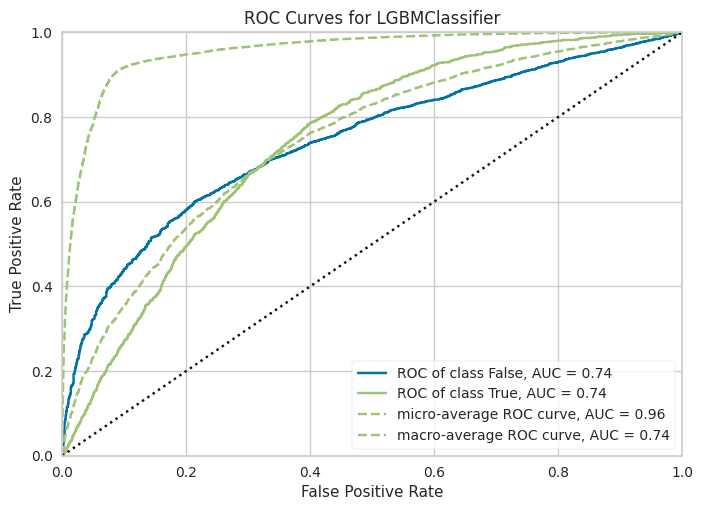

In [63]:
plot_model(tuned_lgbm, plot='auc')

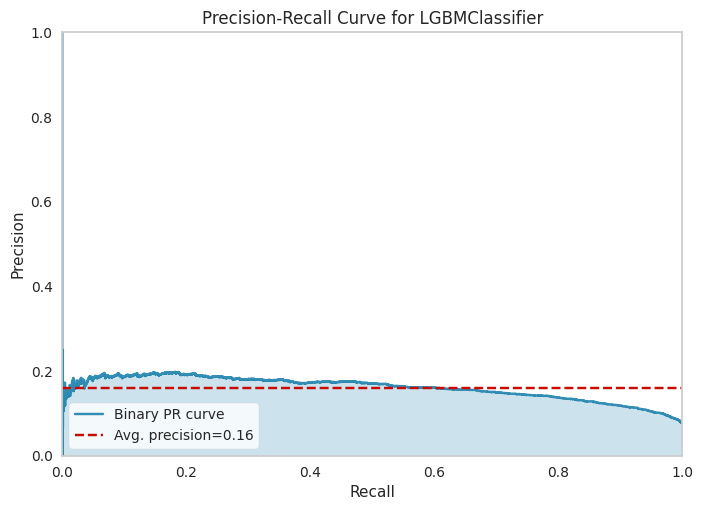

In [64]:
plot_model(tuned_lgbm, plot='pr')

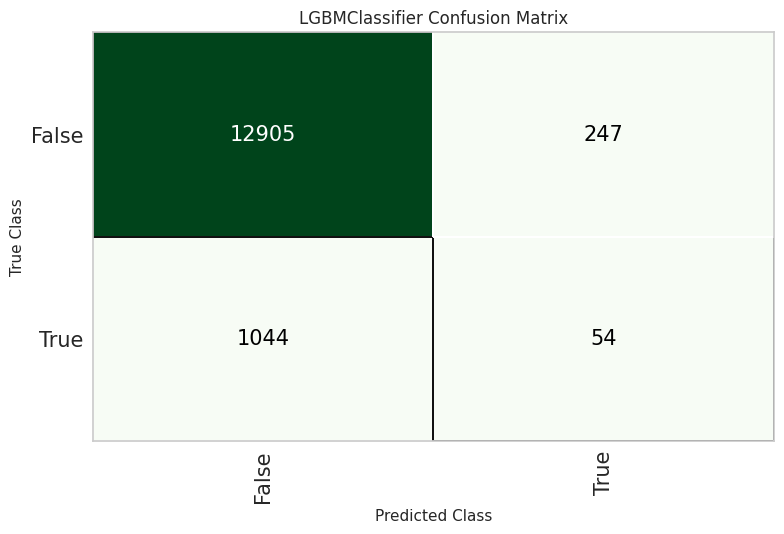

In [65]:
plot_model(tuned_lgbm, plot='confusion_matrix')

In [66]:
predict_model(tuned_lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9094,0.7433,0.0492,0.1794,0.0772,0.0456,0.0564


[LightGBM] [Warning] Unknown parameter: fix_imbalance
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Unknown parameter: fix_imbalance
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
34310,M,N,S,0,Assalariado,Superior completo,Casado,Casa,36,14.435616,2.0,13721.530273,False,0,0.9980
12387,F,N,S,0,Assalariado,Médio,Casado,Casa,52,14.054794,2.0,30558.009766,False,0,0.9967
2403,F,N,S,0,Pensionista,Médio,Casado,Casa,66,NaN,2.0,1494.670044,False,0,0.8437
18126,M,N,N,0,Servidor público,Médio,Casado,Casa,41,0.578082,2.0,3058.110107,False,0,0.6886
42624,F,N,S,2,Assalariado,Superior completo,Casado,Casa,37,15.646575,4.0,29369.550781,False,0,0.9995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32369,F,N,S,0,Assalariado,Médio,União,Casa,53,8.742466,2.0,412.309998,False,1,0.7600
46967,M,S,S,1,Assalariado,Superior completo,Casado,Casa,28,5.931507,3.0,7880.160156,False,0,0.9821
36000,F,N,S,2,Assalariado,Médio,Separado,Casa,31,9.416438,3.0,2781.239990,False,0,0.9614
42985,M,S,N,0,Assalariado,Médio,Casado,Casa,52,10.030137,2.0,35787.511719,False,0,0.9987


In [67]:
# Preparando para salvar o modelo.
final_lgbm = finalize_model(tuned_lgbm)

In [68]:
#Salvando localmente.
save_model(final_lgbm, 'Final LGBM Model 10jan2024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 colsample_bytree=1.0, feature_fraction=0.5,
         